In [33]:
!make docker-image > /dev/null 2>&1

In [34]:
!CONTAINER_CMD="bash -lc 'make install-ycsb'" make docker > /dev/null 2>&1

In [35]:
from pathlib import Path
import pexpect
import os
import time

""" Collector class has helper methods to interact with kermit"""
class Collector: 
    def __init__(self, config: Path):
        self.env = os.environ.copy()
        self.env["INTERACTIVE"] = "it"
        self.env["CONTAINER_CMD"] = f"bash -lc 'KERNMLOPS_CONFIG_FILE={config} make collect-data'"
        self.collect_process : pexpect.spawn | None = None

    def start_collection(self, logfile=None):
        self.collect_process = pexpect.spawn("make docker", env=self.env, timeout=None, logfile=logfile)
        self.collect_process.expect_exact(["Started benchmark"])

    def _after_run_generate_file_data() -> dict[str, list[Path]]:
        start_path : Path = Path("./data")
        list_of_collect_id_dirs = start_path.glob("*/*/*")
        latest_collect_id = max(list_of_collect_id_dirs, key=os.path.getctime)
        list_of_files = latest_collect_id.glob("*.*.parquet")
        output = {}
        for f in list_of_files:
            index = str(f).removeprefix(str(f.parent) + "/").split(".")[0]
            if index not in output.keys():
                output[index] = []
            output[index].append(f)
        return output
        
    def wait(self) -> int:
        if self.collect_process is None:
            return
        self.collect_process.expect([pexpect.EOF])
        self.collect_process.wait()
        return Collector._after_run_generate_file_data()
        
    def stop_collection(self):
        if self.collect_process is None:
            return
        self.collect_process.sendline("END")
        return self.wait()

In [36]:
import polars as pl

def normalize_function_hits(df: pl.DataFrame, function_col: str = 'function', output_scale: str = 'percentage') -> pl.DataFrame:
    """
    Processes raw trace hits to normalized function frequencies using Polars.
    
    Args:
        df: Polars DataFrame where each row is a single trace hit.
        function_col: Column containing function names (default: 'function').
        output_scale: 'percentage' (0-100%) or 'range' ([0,1]) (default: 'percentage').
    
    Returns:
        Polars DataFrame with columns: [function, count, normalized], sorted by normalized desc.
    """
    # Count hits per function
    func_counts = df.group_by(function_col).agg(pl.count().alias('count'))

    if output_scale == 'percentage':
        total = func_counts['count'].sum()
        func_counts = func_counts.with_columns(
            (pl.col('count') / total * 100).alias('normalized')
        )
    elif output_scale == 'range':
        min_val = func_counts['count'].min()
        max_val = func_counts['count'].max()
        if min_val == max_val:
            func_counts = func_counts.with_columns(
                pl.lit(0.0).alias('normalized')
            )
        else:
            func_counts = func_counts.with_columns(
                ((pl.col('count') - min_val) / (max_val - min_val)).alias('normalized')
            )
    else:
        raise ValueError("output_scale must be 'percentage' or 'range'")
    
    return func_counts.sort('normalized', descending=True)

In [37]:
import polars as pl

def normalize_function_hits_relative(
    df: pl.DataFrame,
    function_col: str = 'function',
    entry_name: str = None
) -> pl.DataFrame:
    """
    Processes raw trace hits to normalized function frequencies relative to a given entry.

    Args:
        df: Polars DataFrame where each row is a single trace hit.
        function_col: Column containing function names (default: 'function').
        entry_name: The function name to normalize against. Its count will map to 1.0.

    Returns:
        Polars DataFrame with columns: [function, count, normalized], sorted by normalized descending.

    Raises:
        ValueError: if entry_name is not found or has zero count.
    """
    if entry_name is None:
        raise ValueError("You must provide an entry_name to normalize against.")

    # 1) Count hits per function
    func_counts = (
        df
        .groupby(function_col)
        .agg(pl.count().alias('count'))
    )

    # 2) Ensure the reference function exists
    counts_map = dict(zip(func_counts[function_col].to_list(),
                          func_counts['count'].to_list()))
    if entry_name not in counts_map:
        raise ValueError(f"Reference '{entry_name}' not found in column '{function_col}'.")
    entry_count = counts_map[entry_name]
    if entry_count == 0:
        raise ValueError(f"Reference '{entry_name}' has zero hits; cannot normalize.")

    # 3) Compute relative normalization
    func_counts = func_counts.with_columns(
        (pl.col('count') / entry_count).alias('normalized')
    )

    # 4) Sort by normalized value descending
    return func_counts.sort('normalized', descending=True)


## Define Data Collection Function

In [38]:
import polars as pl

def collect_benchmark_data(yaml_path, subsystem_key = "scheduler_core"):
    # Collect the data for passed in benchmark
    collect = Collector("./config/" + yaml_path)

    w = open("hello.txt", "bw")
    collect.start_collection(logfile=w)
    # Start collection

    coll_info = collect.wait()
    #Wait for collector to finish

    df = pl.read_parquet(coll_info[subsystem_key])
    return df

In [39]:
benchmarks = {
    "redis": "start_overrides.yaml",
    "xsbench": "xsbench.yaml",
    "memcached": "memcached.yaml",
    "fio": "fio.yaml",
}

In [40]:
benchmark_data = {}

for key in benchmarks:
    print("Starting data collection for " + key)
    benchmark_data[key] = collect_benchmark_data(benchmarks[key])
    print("Completed data collection for " + key)


Starting data collection for redis
Completed data collection for redis
Starting data collection for xsbench
Completed data collection for xsbench
Starting data collection for memcached
Completed data collection for memcached
Starting data collection for fio
Completed data collection for fio


## Processing and Analysis

### Assign Labels to Offsets

In [65]:
instr_to_label = {
    "pick_next_task_fair": "entry",
    "pick_next_task_fair+0x31": "idle",
    "pick_next_task_fair+0x126": "done",
    "pick_next_task_fair+0xa4": "while_is_group",
    "pick_next_task_fair+0x1d3": "while_different_groups",
    "pick_next_task_fair+0x56": "again",
    "first_loop": "while_is_group",
    "second_loop": "while_different_groups",
}

In [66]:
for key in benchmark_data:
    df_copy = benchmark_data[key].clone()
    df_copy = df_copy.with_columns(pl.col("event_name").replace(instr_to_label).alias("event_name"))
    benchmark_data[key] = df_copy

In [67]:
print(benchmark_data)

{'redis': shape: (447_985, 9)
┌─────┬────────┬────────┬──────────────┬───┬───────┬──────┬────────────────┬───────────────────────┐
│ cpu ┆ pid    ┆ tgid   ┆ ts_uptime_us ┆ … ┆ flags ┆ mode ┆ event_name     ┆ collection_id         │
│ --- ┆ ---    ┆ ---    ┆ ---          ┆   ┆ ---   ┆ ---  ┆ ---            ┆ ---                   │
│ i64 ┆ i64    ┆ i64    ┆ i64          ┆   ┆ i64   ┆ i64  ┆ str            ┆ str                   │
╞═════╪════════╪════════╪══════════════╪═══╪═══════╪══════╪════════════════╪═══════════════════════╡
│ 0   ┆ 245012 ┆ 244865 ┆ 607984908266 ┆ … ┆ 0     ┆ 0    ┆ entry          ┆ 7a4484ef-f6a6-4881-b8 │
│     ┆        ┆        ┆              ┆   ┆       ┆      ┆                ┆ d1-9929f8…            │
│ 0   ┆ 245012 ┆ 244865 ┆ 607984908281 ┆ … ┆ 0     ┆ 0    ┆ while_is_group ┆ 7a4484ef-f6a6-4881-b8 │
│     ┆        ┆        ┆              ┆   ┆       ┆      ┆                ┆ d1-9929f8…            │
│ 0   ┆ 245012 ┆ 244865 ┆ 607984908284 ┆ … ┆ 0     ┆ 0    ┆ w

### Normalization

In [68]:
normalized_benchmark_data = {}

for key in benchmark_data:
    normalized_benchmark_data[key] = normalize_function_hits(benchmark_data[key], function_col="event_name")

/tmp/ipykernel_231947/3404100469.py:16: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  func_counts = df.group_by(function_col).agg(pl.count().alias('count'))


In [69]:
print(normalized_benchmark_data)

{'redis': shape: (5, 3)
┌────────────────────────┬────────┬────────────┐
│ event_name             ┆ count  ┆ normalized │
│ ---                    ┆ ---    ┆ ---        │
│ str                    ┆ u32    ┆ f64        │
╞════════════════════════╪════════╪════════════╡
│ entry                  ┆ 177082 ┆ 39.528556  │
│ idle                   ┆ 149850 ┆ 33.449781  │
│ while_is_group         ┆ 70993  ┆ 15.847182  │
│ done                   ┆ 27610  ┆ 6.163153   │
│ while_different_groups ┆ 22450  ┆ 5.011329   │
└────────────────────────┴────────┴────────────┘, 'xsbench': shape: (5, 3)
┌────────────────────────┬─────────┬────────────┐
│ event_name             ┆ count   ┆ normalized │
│ ---                    ┆ ---     ┆ ---        │
│ str                    ┆ u32     ┆ f64        │
╞════════════════════════╪═════════╪════════════╡
│ entry                  ┆ 3385586 ┆ 42.347902  │
│ idle                   ┆ 3047376 ┆ 38.117472  │
│ while_is_group         ┆ 922310  ┆ 11.536524  │
│ done     

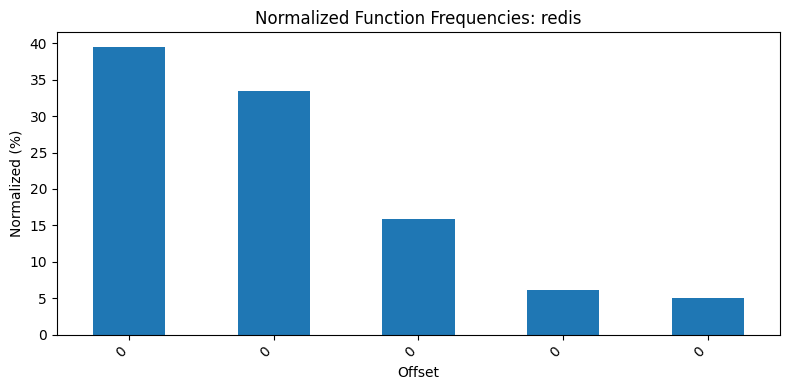

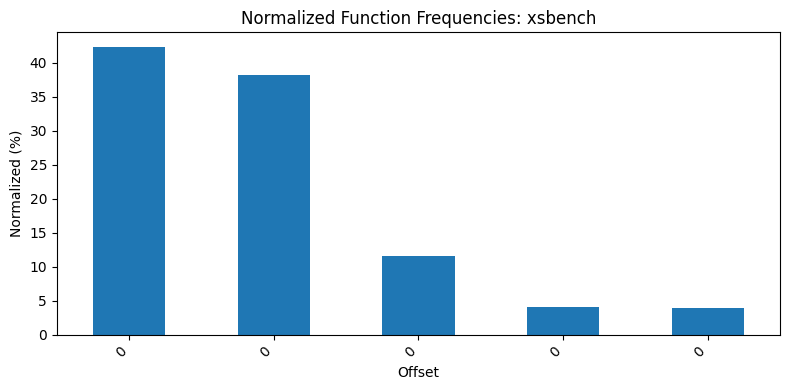

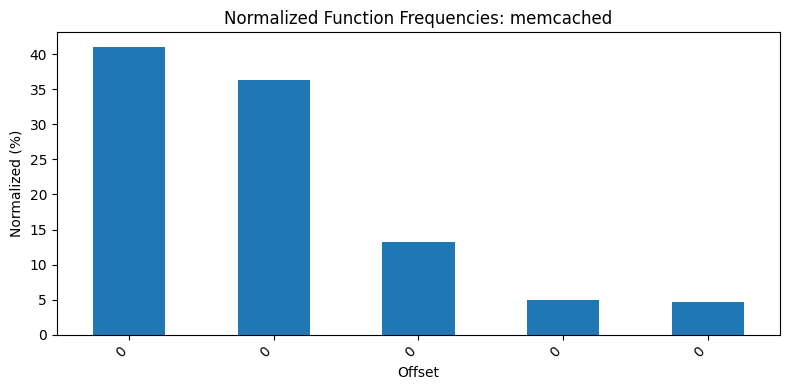

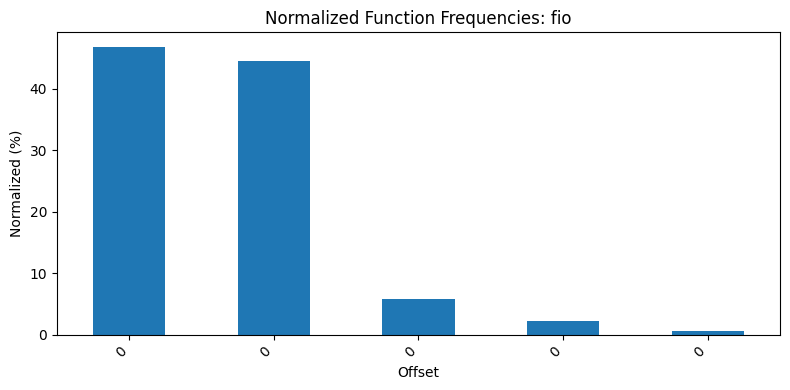

<Figure size 1000x600 with 0 Axes>

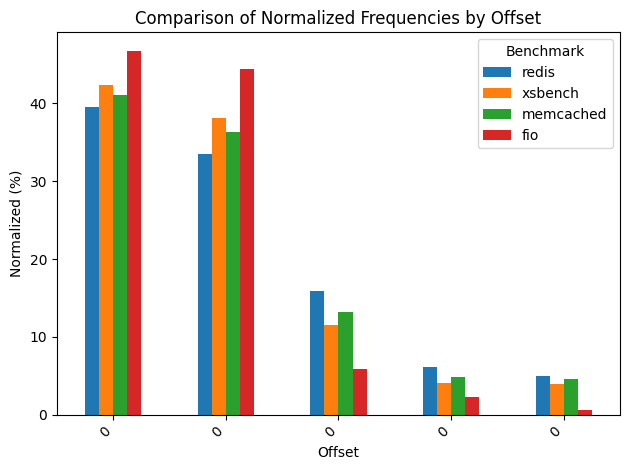

In [70]:
import matplotlib.pyplot as plt
import pandas as pd

# helper to pull off the part after '+' or return '0'
def extract_offset(event_name: str) -> str:
    parts = event_name.split("+", 1)
    return parts[1] if len(parts) == 2 else "0"

# 1) One chart per benchmark, x-axis = Offset
for bench_name, pl_df in normalized_benchmark_data.items():
    # to pandas and compute Offset
    pdf = (
        pl_df
        .select(["event_name", "normalized"])
        .to_pandas()
    )
    pdf["Offset"] = pdf["event_name"].apply(extract_offset)
    pdf = pdf.set_index("Offset")

    plt.figure(figsize=(8, 4))
    pdf["normalized"].plot(kind="bar")
    plt.title(f"Normalized Function Frequencies: {bench_name}")
    plt.xlabel("Offset")
    plt.ylabel("Normalized (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# 2) Combined chart, all benchmarks on one grouped-bar plot
# Build a wide-form DataFrame indexed by Offset
combined = pd.DataFrame()
for bench_name, pl_df in normalized_benchmark_data.items():
    pdf = (
        pl_df
        .select(["event_name", "normalized"])
        .to_pandas()
    )
    pdf["Offset"] = pdf["event_name"].apply(extract_offset)
    pdf = pdf.set_index("Offset")
    combined[bench_name] = pdf["normalized"]

# Fill missing offsets with zero
combined = combined.fillna(0)

plt.figure(figsize=(10, 6))
combined.plot(kind="bar")
plt.title("Comparison of Normalized Frequencies by Offset")
plt.xlabel("Offset")
plt.ylabel("Normalized (%)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Benchmark")
plt.tight_layout()
plt.show()


### Relative Frequencies to Entry

In [71]:
import polars as pl

def normalize_function_hits_relative(
    df: pl.DataFrame,
    function_col: str = 'function',
    entry_name: str = None
) -> pl.DataFrame:
    """
    Processes raw trace hits to normalized function frequencies relative to a given entry.

    Args:
        df: Polars DataFrame where each row is a single trace hit.
        function_col: Column containing function names (default: 'function').
        entry_name: The function name to normalize against. Its count will map to 1.0.

    Returns:
        Polars DataFrame with columns: [function, count, normalized], sorted by normalized descending.

    Raises:
        ValueError: if entry_name is not found or has zero count.
    """
    if entry_name is None:
        raise ValueError("You must provide an entry_name to normalize against.")

    # 1) Count hits per function
    func_counts = (
        df
        .group_by(function_col)
        .agg(pl.count().alias('count'))
    )

    # 2) Ensure the reference function exists
    counts_map = dict(zip(func_counts[function_col].to_list(),
                          func_counts['count'].to_list()))
    if entry_name not in counts_map:
        raise ValueError(f"Reference '{entry_name}' not found in column '{function_col}'.")
    entry_count = counts_map[entry_name]
    if entry_count == 0:
        raise ValueError(f"Reference '{entry_name}' has zero hits; cannot normalize.")

    # 3) Compute relative normalization
    func_counts = func_counts.with_columns(
        (pl.col('count') / entry_count).alias('normalized')
    )

    # 4) Sort by normalized value descending
    return func_counts.sort('normalized', descending=True)


In [72]:
relative_benchmark_data = {}

for key in benchmark_data:
    relative_benchmark_data[key] = normalize_function_hits_relative(benchmark_data[key], function_col="event_name", entry_name= "entry")

/tmp/ipykernel_231947/4148123003.py:29: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias('count'))


In [73]:
print(relative_benchmark_data)

{'redis': shape: (5, 3)
┌────────────────────────┬────────┬────────────┐
│ event_name             ┆ count  ┆ normalized │
│ ---                    ┆ ---    ┆ ---        │
│ str                    ┆ u32    ┆ f64        │
╞════════════════════════╪════════╪════════════╡
│ entry                  ┆ 177082 ┆ 1.0        │
│ idle                   ┆ 149850 ┆ 0.846218   │
│ while_is_group         ┆ 70993  ┆ 0.400905   │
│ done                   ┆ 27610  ┆ 0.155916   │
│ while_different_groups ┆ 22450  ┆ 0.126777   │
└────────────────────────┴────────┴────────────┘, 'xsbench': shape: (5, 3)
┌────────────────────────┬─────────┬────────────┐
│ event_name             ┆ count   ┆ normalized │
│ ---                    ┆ ---     ┆ ---        │
│ str                    ┆ u32     ┆ f64        │
╞════════════════════════╪═════════╪════════════╡
│ entry                  ┆ 3385586 ┆ 1.0        │
│ idle                   ┆ 3047376 ┆ 0.900103   │
│ while_is_group         ┆ 922310  ┆ 0.272423   │
│ done     

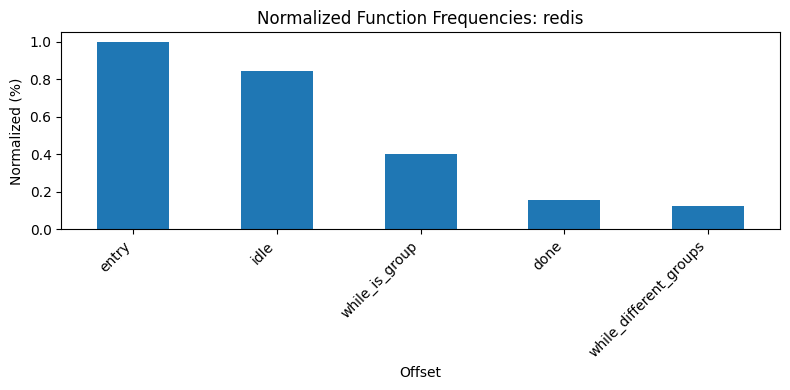

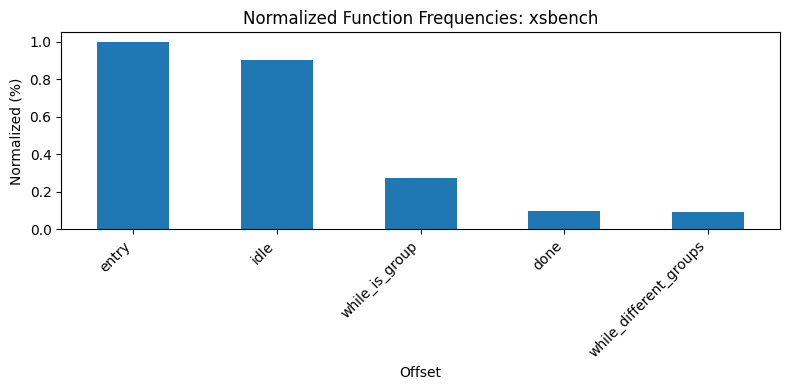

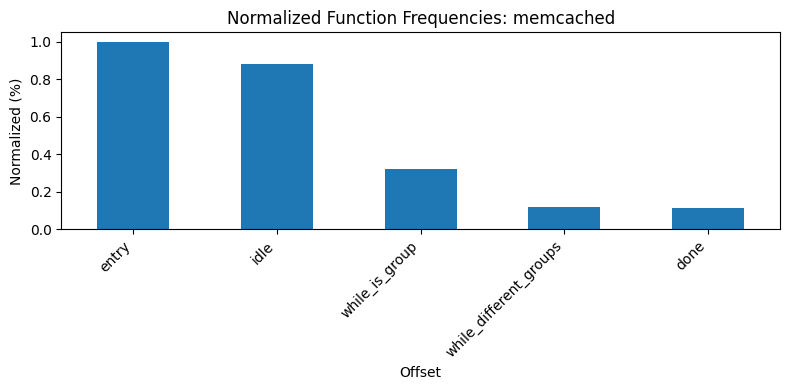

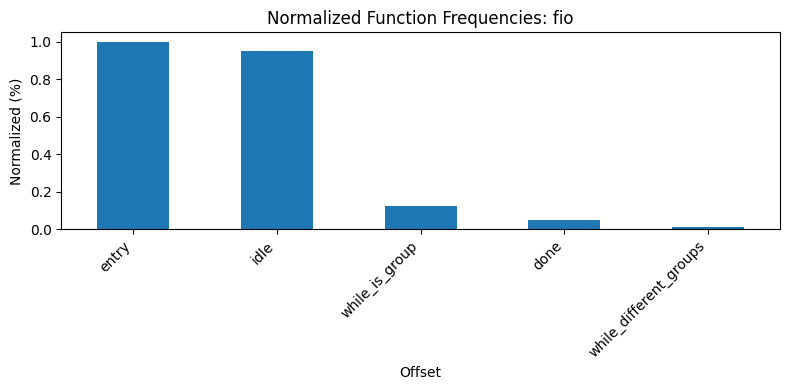

<Figure size 1000x600 with 0 Axes>

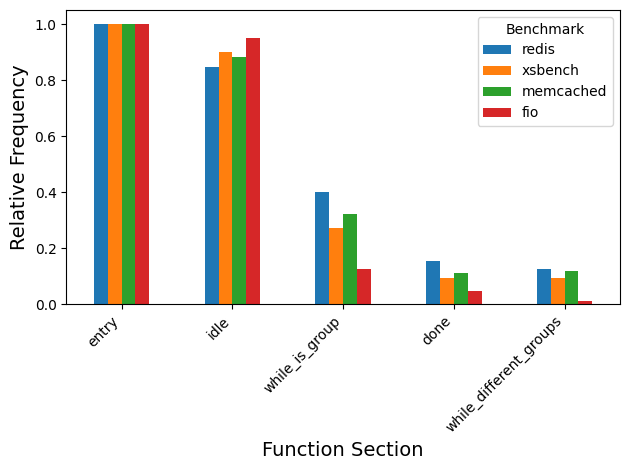

In [74]:
import matplotlib.pyplot as plt
import pandas as pd

# helper to pull off the part after '+' or return '0'
def extract_offset(event_name: str) -> str:
    parts = event_name.split("+", 1)
    return parts[1] if len(parts) == 2 else "0"

# 1) One chart per benchmark, x-axis = Offset
for bench_name, pl_df in relative_benchmark_data.items():
    # to pandas and compute Offset
    pdf = (
        pl_df
        .select(["event_name", "normalized"])
        .to_pandas()
    )
    pdf = pdf.set_index("event_name")

    plt.figure(figsize=(8, 4))
    pdf["normalized"].plot(kind="bar")
    plt.title(f"Normalized Function Frequencies: {bench_name}")
    plt.xlabel("Offset")
    plt.ylabel("Normalized (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# 2) Combined chart, all benchmarks on one grouped-bar plot
# Build a wide-form DataFrame indexed by Offset
combined = pd.DataFrame()
for bench_name, pl_df in relative_benchmark_data.items():
    pdf = (
        pl_df
        .select(["event_name", "normalized"])
        .to_pandas()
    )
    pdf = pdf.set_index("event_name")
    combined[bench_name] = pdf["normalized"]

# Fill missing offsets with zero
combined = combined.fillna(0)

plt.figure(figsize=(10, 6))
combined.plot(kind="bar")
plt.xlabel("Function Section", fontsize = 14)
plt.ylabel("Relative Frequency", fontsize = 14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Benchmark")
plt.tight_layout()
plt.savefig('graph-images/relative-grouped.png', dpi=300)
plt.show()


### Consecutive Events Analysis

In [105]:
def count_consecutive_events(df, event_name):
    """
    Count consecutive occurrences of a specific event and return frequency distribution.
    
    Parameters:
    df (pl.DataFrame): Input dataframe with columns including 'ts_uptime_us' and 'event_name'
    event_name (str): The specific event name to analyze
    
    Returns:
    pl.DataFrame: DataFrame with columns 'consecutive_count' and 'frequency'
                 where consecutive_count is the number of times the event occurred
                 consecutively, and frequency is how often that count occurs
    """
    
    # Sort by timestamp to ensure proper ordering
    df_sorted = df.sort('ts_uptime_us')
    
    # Create a boolean column for the target event
    df_with_event = df_sorted.with_columns(
        pl.col('event_name').eq(event_name).alias('is_target_event')
    )
    
    # Create groups of consecutive events using cumulative sum
    # When the event changes, the cumulative sum increases
    df_with_groups = df_with_event.with_columns(
        pl.col('is_target_event').ne(pl.col('is_target_event').shift(1, fill_value=False))
        .cum_sum()
        .alias('group_id')
    )
    
    # Count consecutive occurrences for each group
    consecutive_counts = (
        df_with_groups
        .filter(pl.col('is_target_event'))  # Only keep rows with target event
        .group_by('group_id')
        .agg(pl.len().alias('consecutive_count'))
        .select('consecutive_count')
    )
    
    # Calculate frequency distribution
    frequency_distribution = (
        consecutive_counts
        .group_by('consecutive_count')
        .agg(pl.len().alias('frequency'))
        .sort('consecutive_count')
    )
    
    return frequency_distribution

In [106]:
loop_instructions = [
    "while_is_group",
    "while_different_groups",
]

In [107]:
loop_benchmark_data = {}

for key in benchmark_data:
    for instr in loop_instructions:
        if key not in loop_benchmark_data:
            loop_benchmark_data[key] = {instr: count_consecutive_events(benchmark_data[key], event_name=instr)}
        else:
            loop_benchmark_data[key][instr] = count_consecutive_events(benchmark_data[key], event_name=instr)

In [108]:
print(loop_benchmark_data)

{'redis': {'while_is_group': shape: (8, 2)
┌───────────────────┬───────────┐
│ consecutive_count ┆ frequency │
│ ---               ┆ ---       │
│ u32               ┆ u32       │
╞═══════════════════╪═══════════╡
│ 1                 ┆ 9542      │
│ 2                 ┆ 1152      │
│ 3                 ┆ 13978     │
│ 4                 ┆ 4121      │
│ 5                 ┆ 48        │
│ 6                 ┆ 42        │
│ 7                 ┆ 27        │
│ 8                 ┆ 6         │
└───────────────────┴───────────┘, 'while_different_groups': shape: (6, 2)
┌───────────────────┬───────────┐
│ consecutive_count ┆ frequency │
│ ---               ┆ ---       │
│ u32               ┆ u32       │
╞═══════════════════╪═══════════╡
│ 1                 ┆ 2955      │
│ 2                 ┆ 2639      │
│ 3                 ┆ 4713      │
│ 4                 ┆ 10        │
│ 5                 ┆ 4         │
│ 6                 ┆ 3         │
└───────────────────┴───────────┘}, 'xsbench': {'while_is_group': 

In [109]:
for key in benchmark_data:
    for instr in loop_instructions:
        print(key, loop_benchmark_data[key][instr])

redis shape: (8, 2)
┌───────────────────┬───────────┐
│ consecutive_count ┆ frequency │
│ ---               ┆ ---       │
│ u32               ┆ u32       │
╞═══════════════════╪═══════════╡
│ 1                 ┆ 9542      │
│ 2                 ┆ 1152      │
│ 3                 ┆ 13978     │
│ 4                 ┆ 4121      │
│ 5                 ┆ 48        │
│ 6                 ┆ 42        │
│ 7                 ┆ 27        │
│ 8                 ┆ 6         │
└───────────────────┴───────────┘
redis shape: (6, 2)
┌───────────────────┬───────────┐
│ consecutive_count ┆ frequency │
│ ---               ┆ ---       │
│ u32               ┆ u32       │
╞═══════════════════╪═══════════╡
│ 1                 ┆ 2955      │
│ 2                 ┆ 2639      │
│ 3                 ┆ 4713      │
│ 4                 ┆ 10        │
│ 5                 ┆ 4         │
│ 6                 ┆ 3         │
└───────────────────┴───────────┘
xsbench shape: (8, 2)
┌───────────────────┬───────────┐
│ consecutive_count 

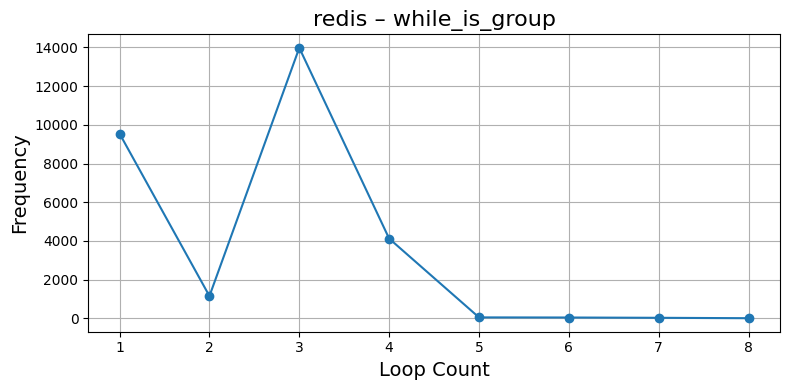

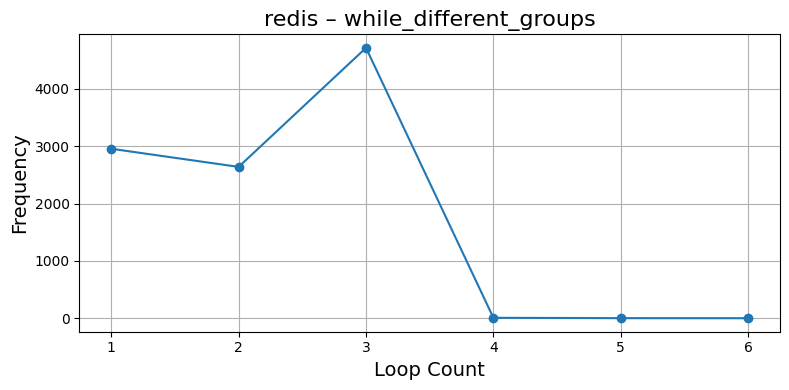

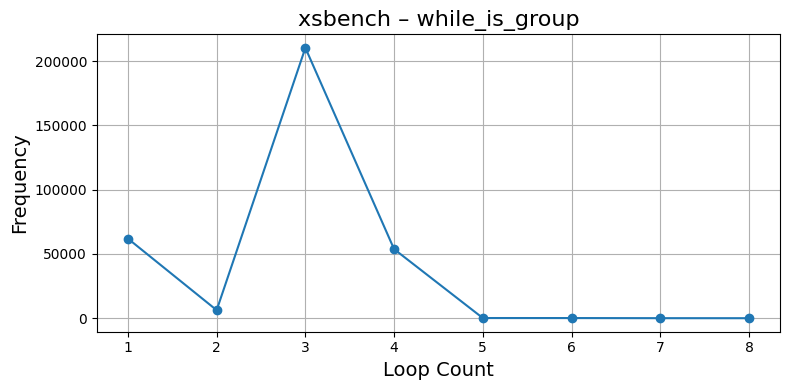

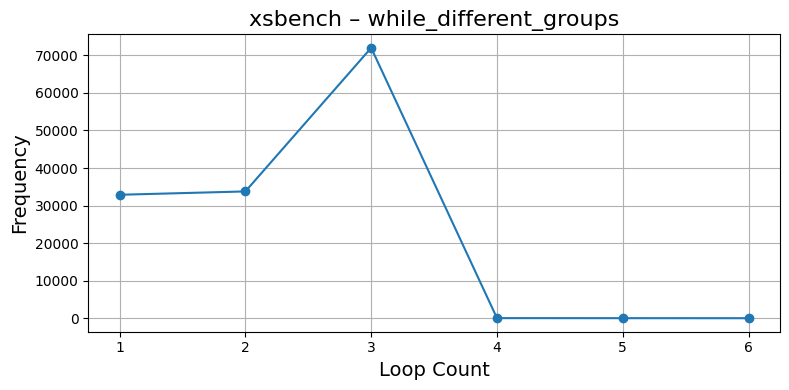

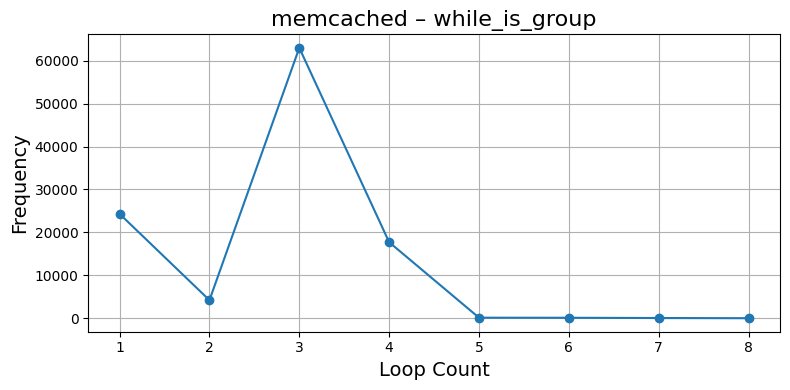

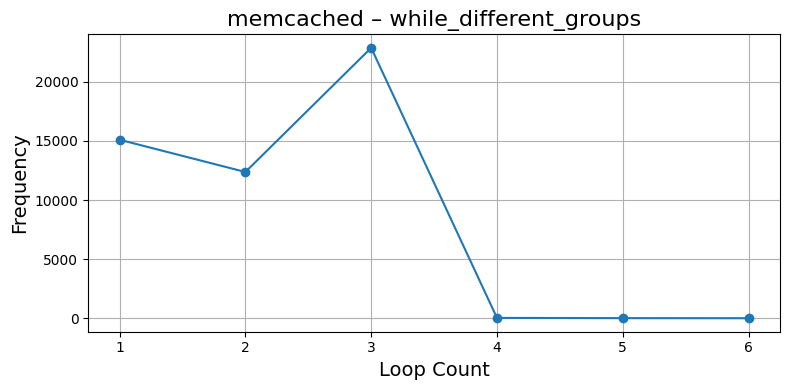

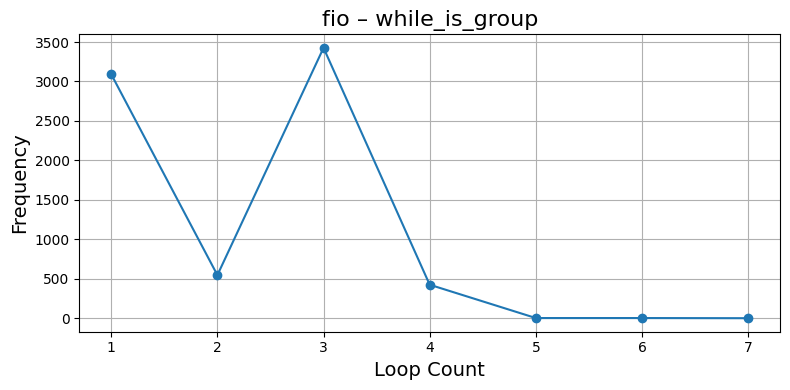

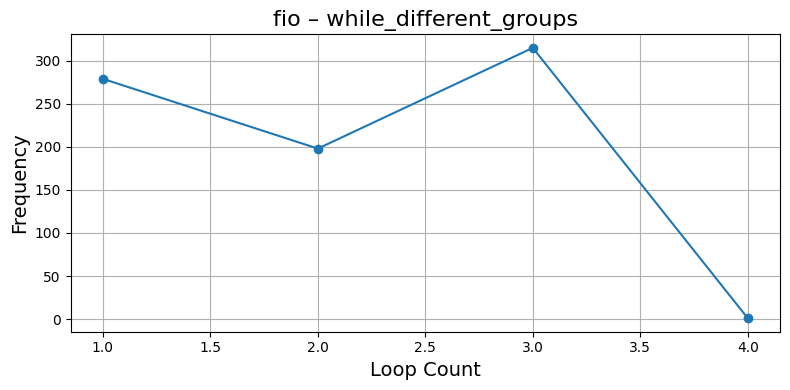

In [110]:
import matplotlib.pyplot as plt

# assume loop_benchmark_data is defined as:
# {
#    'redis': {
#        'pick_next_task_fair+0xa4': <polars.DataFrame>,
#        ...
#    },
#    'xsbench': {
#        'pick_next_task_fair+0xa4': <polars.DataFrame>,
#        ...
#    },
#    ...
# }

for bench_name, instr_dict in loop_benchmark_data.items():
    for instr, pl_df in instr_dict.items():
        # sort by consecutive_count so the line plot is monotonic in x
        df_sorted = pl_df.sort("consecutive_count")
        # convert to pandas for plotting
        pdf = df_sorted.to_pandas()

        plt.figure(figsize=(8, 4))
        plt.plot(
            pdf["consecutive_count"],
            pdf["frequency"],
            marker="o",
            linestyle="-"
        )
        plt.xlabel("Loop Count", fontsize =14)
        plt.ylabel("Frequency", fontsize = 14)
        plt.title(f"{bench_name} – {instr}", fontsize = 16)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("graph-images/" + bench_name + "–" + instr + ".png", dpi=300)
        plt.show()


Remove Outliers

In [111]:
no_outliers_loop_data = {}

In [101]:
import polars as pl

# Define the minimum frequency threshold: 
# here we drop any consecutive_count whose frequency == 1
min_freq = 3

# Filter out “outliers” (i.e. rows with frequency < min_freq)
for bench_name, instr_dict in loop_benchmark_data.items():
    for instr, pl_df in instr_dict.items():
        cleaned_df = pl_df.filter(
            pl.col("frequency") >= min_freq
        )
        # replace the original with the filtered version
        if bench_name not in no_outliers_loop_data:
            no_outliers_loop_data[bench_name] = {instr: cleaned_df}
        else:
            no_outliers_loop_data[bench_name][instr] = cleaned_df

# Now you can run your plotting loop on loop_benchmark_data
print(no_outliers_loop_data)

{'redis': {'while_is_group': shape: (4, 2)
┌───────────────────┬───────────┐
│ consecutive_count ┆ frequency │
│ ---               ┆ ---       │
│ u32               ┆ u32       │
╞═══════════════════╪═══════════╡
│ 1                 ┆ 8170      │
│ 2                 ┆ 6         │
│ 3                 ┆ 14837     │
│ 4                 ┆ 4575      │
└───────────────────┴───────────┘, 'while_different_groups': shape: (3, 2)
┌───────────────────┬───────────┐
│ consecutive_count ┆ frequency │
│ ---               ┆ ---       │
│ u32               ┆ u32       │
╞═══════════════════╪═══════════╡
│ 1                 ┆ 2274      │
│ 2                 ┆ 2402      │
│ 3                 ┆ 5124      │
└───────────────────┴───────────┘}, 'xsbench': {'while_is_group': shape: (5, 2)
┌───────────────────┬───────────┐
│ consecutive_count ┆ frequency │
│ ---               ┆ ---       │
│ u32               ┆ u32       │
╞═══════════════════╪═══════════╡
│ 1                 ┆ 54962     │
│ 2                 

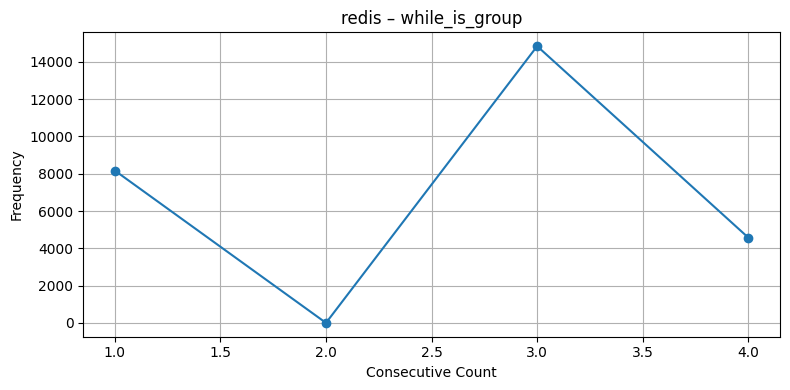

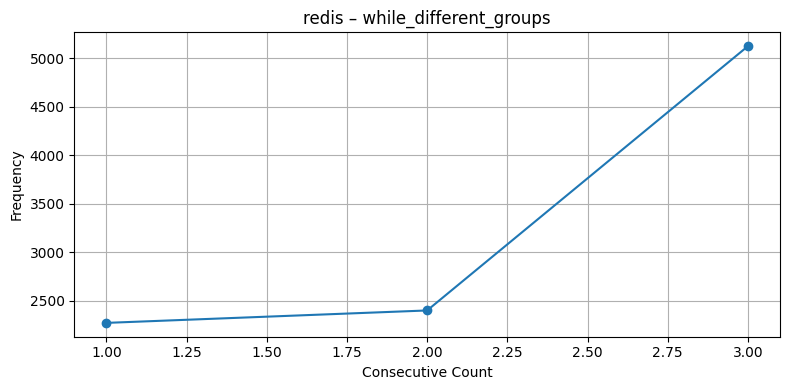

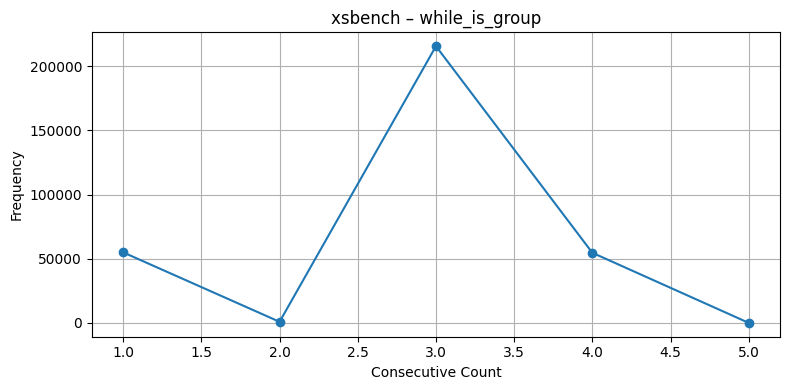

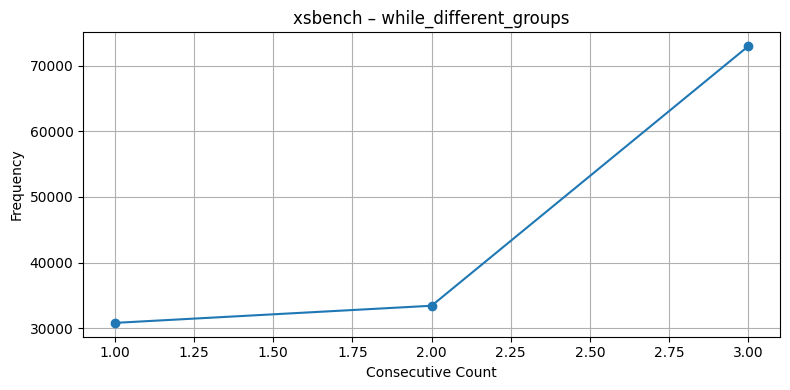

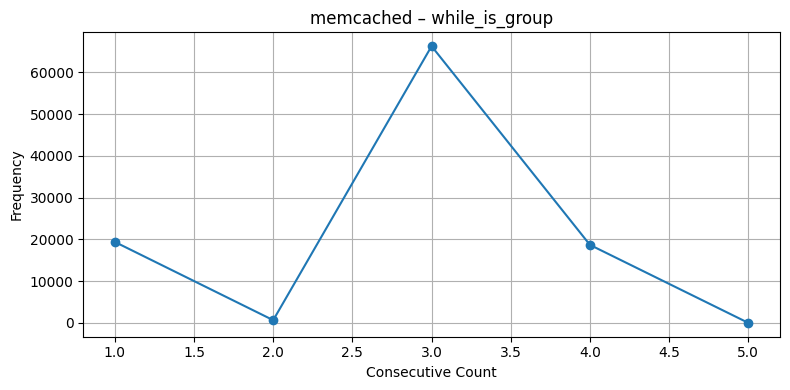

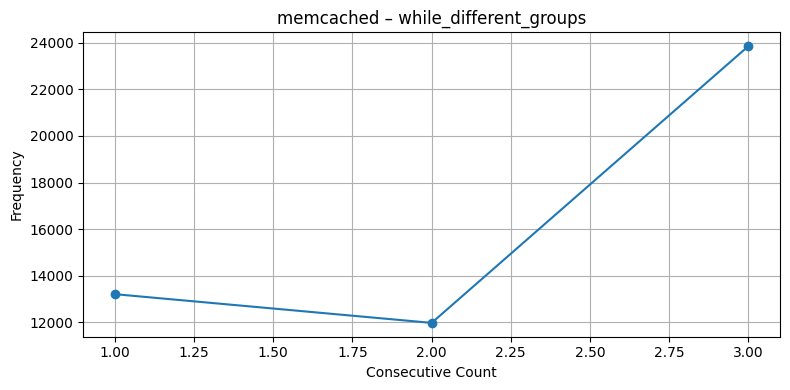

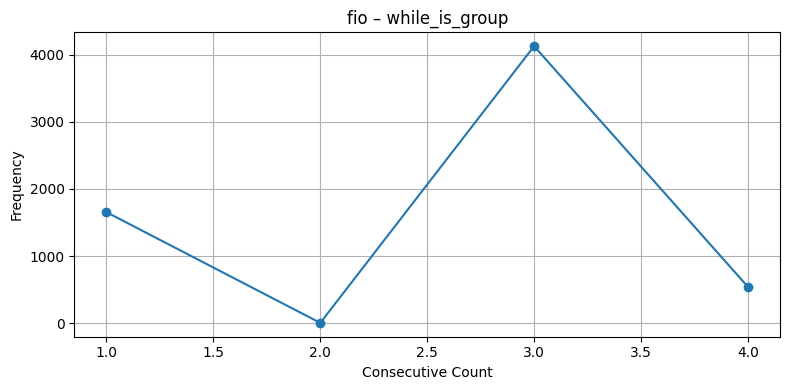

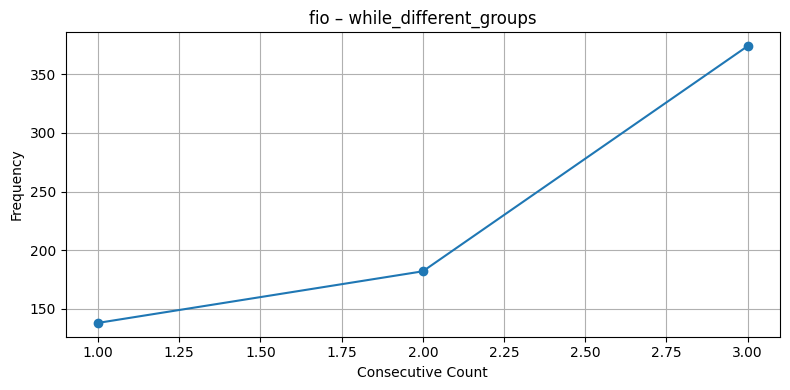

In [102]:
import matplotlib.pyplot as plt

# assume loop_benchmark_data is defined as:
# {
#    'redis': {
#        'pick_next_task_fair+0xa4': <polars.DataFrame>,
#        ...
#    },
#    'xsbench': {
#        'pick_next_task_fair+0xa4': <polars.DataFrame>,
#        ...
#    },
#    ...
# }

for bench_name, instr_dict in no_outliers_loop_data.items():
    for instr, pl_df in instr_dict.items():
        # sort by consecutive_count so the line plot is monotonic in x
        df_sorted = pl_df.sort("consecutive_count")
        # convert to pandas for plotting
        pdf = df_sorted.to_pandas()

        plt.figure(figsize=(8, 4))
        plt.plot(
            pdf["consecutive_count"],
            pdf["frequency"],
            marker="o",
            linestyle="-"
        )
        plt.xlabel("Consecutive Count")
        plt.ylabel("Frequency")
        plt.title(f"{bench_name} – {instr}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


### Calculate Mean Consecutive Counts

In [103]:
for bench_name, instr_dict in no_outliers_loop_data.items():
    for instr, pl_df in instr_dict.items():
        # total weight
        total_freq = pl_df["frequency"].sum()
        # weighted sum
        weighted_sum = (pl_df["consecutive_count"] * pl_df["frequency"]).sum()
        # weighted average
        avg_run_length = weighted_sum / total_freq
        print(f"{bench_name} • {instr} average run length = {avg_run_length:.2f}")

redis • while_is_group average run length = 2.57
redis • while_different_groups average run length = 2.29
xsbench • while_is_group average run length = 2.83
xsbench • while_different_groups average run length = 2.31
memcached • while_is_group average run length = 2.80
memcached • while_different_groups average run length = 2.22
fio • while_is_group average run length = 2.56
fio • while_different_groups average run length = 2.34


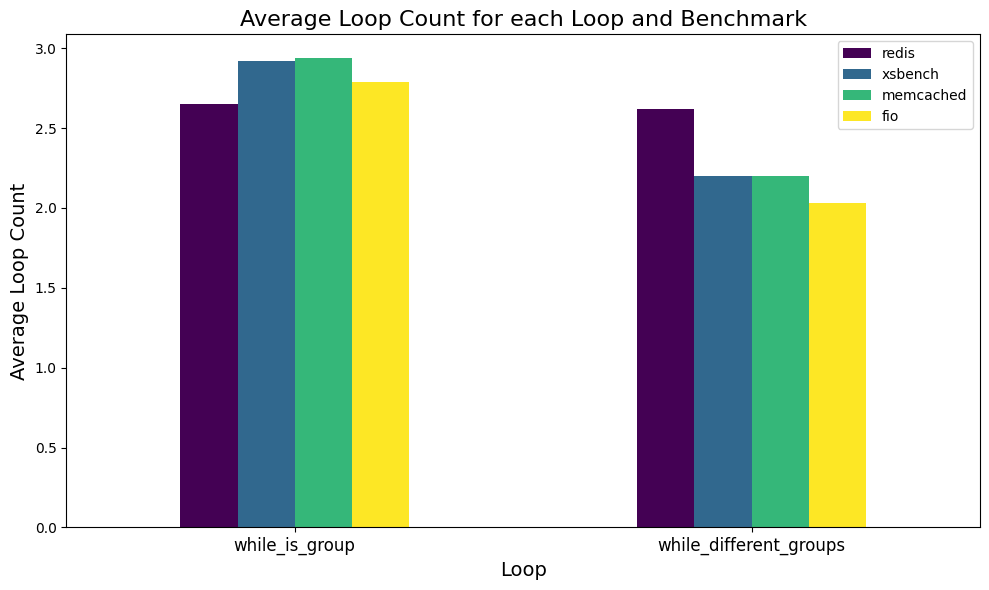

In [104]:
import matplotlib.pyplot as plt
import pandas as pd

# Data provided
data = {
    'redis': [2.65, 2.62],
    'xsbench': [2.92, 2.20],
    'memcached': [2.94, 2.20],
    'fio': [2.79, 2.03]
}

# Creating a DataFrame
df = pd.DataFrame(data, index=['while_is_group', 'while_different_groups'])

# Plotting the data
ax = df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
ax.set_ylabel('Average Loop Count', fontsize=14)
ax.set_title('Average Loop Count for each Loop and Benchmark', fontsize=16)
ax.set_xlabel('Loop', fontsize=14)
plt.xticks(rotation=0, fontsize = 12)
plt.tight_layout()
plt.savefig("graph-images/avg_loops.png", dpi=300)

plt.show()

In [86]:
for bench_name, instr_dict in loop_benchmark_data.items():
    for instr, pl_df in instr_dict.items():
        # total weight
        total_freq = pl_df["frequency"].sum()
        # weighted sum
        weighted_sum = (pl_df["consecutive_count"] * pl_df["frequency"]).sum()
        # weighted average
        avg_run_length = weighted_sum / total_freq
        print(f"{bench_name} • {instr} average run length = {avg_run_length:.2f}")

redis • while_is_group average run length = 2.46
redis • while_different_groups average run length = 2.17
xsbench • while_is_group average run length = 2.77
xsbench • while_different_groups average run length = 2.28
memcached • while_is_group average run length = 2.69
memcached • while_different_groups average run length = 2.16
fio • while_is_group average run length = 2.16
fio • while_different_groups average run length = 2.05


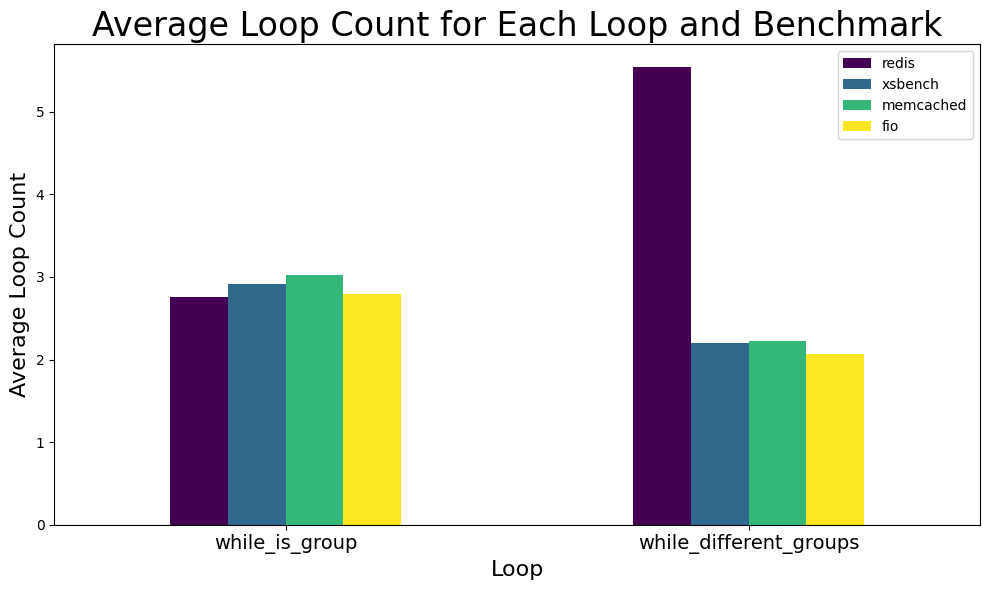

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# Data provided
data = {
    'redis': [2.76, 5.54],
    'xsbench': [2.92, 2.20],
    'memcached': [3.02, 2.23],
    'fio': [2.79, 2.07]
}

# Creating a DataFrame
df = pd.DataFrame(data, index=['while_is_group', 'while_different_groups'])

# Plotting the data
ax = df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
ax.set_ylabel('Average Loop Count', fontsize=16)
ax.set_title('Average Loop Count for Each Loop and Benchmark', fontsize=24)
ax.set_xlabel('Loop', fontsize=16)
plt.xticks(rotation=0, fontsize = 14)
plt.tight_layout()
plt.savefig("graph-images/avg_loops.png", dpi=300)

plt.show()

### Or Medians

In [88]:
for bench_name, instr_dict in loop_benchmark_data.items():
    for instr, pl_df in instr_dict.items():
        # 1) sort by the value
        df_sorted = pl_df.sort("consecutive_count")

        # 2) compute cumulative frequency
        cum = df_sorted.with_columns([
            pl.col("frequency").cum_sum().alias("cum_freq")
        ])

        # 3) find half the total
        total = df_sorted["frequency"].sum()
        half = total / 2

        # 4) pick the first run-length whose cumulative freq ≥ half
        median_row = (
            cum
            .filter(pl.col("cum_freq") >= half)
            .select("consecutive_count")
            .head(1)
        )
        median_run_length = median_row[0, 0]

        print(f"{bench_name} • {instr}  weighted median run length = {median_run_length}")


redis • while_is_group  weighted median run length = 3
redis • while_different_groups  weighted median run length = 2
xsbench • while_is_group  weighted median run length = 3
xsbench • while_different_groups  weighted median run length = 3
memcached • while_is_group  weighted median run length = 3
memcached • while_different_groups  weighted median run length = 2
fio • while_is_group  weighted median run length = 3
fio • while_different_groups  weighted median run length = 2
